<a href="https://colab.research.google.com/github/samobrien878/linearRegression/blob/main/Copy_of_04_hedonic_pricing_completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('airbnb_hw.csv')
df.head()

,Host Id,Host Since,Name,Neighbourhood,Property Type,Review Scores Rating (bin),Room Type,Zipcode,Beds,Number of Records,Number Of Reviews,Price,Review Scores Rating
0,5162530,NaN,1 Bedroom in Prime Williamsburg,Brooklyn,Apartment,NaN,Entire home/apt,11249.0,1.0,1,0,145,NaN
1,33134899,NaN,"Sunny, Private room in Bushwick",Brooklyn,Apartment,NaN,Private room,11206.0,1.0,1,1,37,NaN
2,39608626,NaN,Sunny Room in Harlem,Manhattan,Apartment,NaN,Private room,10032.0,1.0,1,1,28,NaN
3,500,6/26/2008,Gorgeous 1 BR with Private Balcony,Manhattan,Apartment,NaN,Entire home/apt,10024.0,3.0,1,0,199,NaN
4,500,6/26/2008,Trendy Times Square Loft,Manhattan,Apartment,95.0,Private room,10036.0,3.0,1,39,549,96.0


In [3]:
df['Price'] = pd.to_numeric(df['Price'].str.replace(',',''))
df.isnull().sum().sum()
df.columns = df.columns.str.strip()
data = df[['Neighbourhood', 'Property Type', 'Review Scores Rating', 'Price']]
data = data.dropna()
data['Price'] = pd.to_numeric(data['Price'], errors='coerce')

In [4]:
df.columns = df.columns.str.strip()

print(df.groupby('Neighbourhood')['Price'].describe())

                 count        mean         std   min    25%    50%    75%  \
Neighbourhood                                                               
Bronx            345.0   94.660870  218.421021  10.0   50.0   69.0   99.0   
Brooklyn       11675.0  129.500471  155.387024  10.0   70.0  100.0  150.0   
Manhattan      16033.0  198.474584  221.814807  20.0  100.0  155.0  225.0   
Queens          2278.0  103.222125  119.559563  25.0   60.0   80.0  120.0   
Staten Island    147.0  163.462585  450.109002  35.0   59.0   79.0  109.0   

                   max  
Neighbourhood           
Bronx           4000.0  
Brooklyn        8000.0  
Manhattan      10000.0  
Queens          4000.0  
Staten Island   5000.0  


In [83]:
print(df.groupby('Property Type')['Price'].describe())

                   count        mean         std    min     25%    50%  \
Property Type                                                            
Apartment        27102.0  162.045642  181.376882   10.0   85.00  130.0   
Bed & Breakfast    180.0  106.572222   84.701977   30.0   65.00   87.5   
Boat                 8.0  153.625000   49.231051  100.0  120.00  137.5   
Bungalow             4.0  150.750000   46.464144   87.0  133.50  160.5   
Cabin                2.0  165.000000  120.208153   80.0  122.50  165.0   
Camper/RV            7.0  103.571429  102.343958   39.0   47.00   49.0   
Castle               1.0  150.000000         NaN  150.0  150.00  150.0   
Chalet               1.0   99.000000         NaN   99.0   99.00   99.0   
Condominium         94.0  256.585106  249.357946   46.0  131.25  175.0   
Dorm                31.0   76.354839   42.424481   30.0   52.50   65.0   
House             2090.0  156.722967  307.116948   10.0   60.00   85.0   
Hut                  2.0   75.000000  

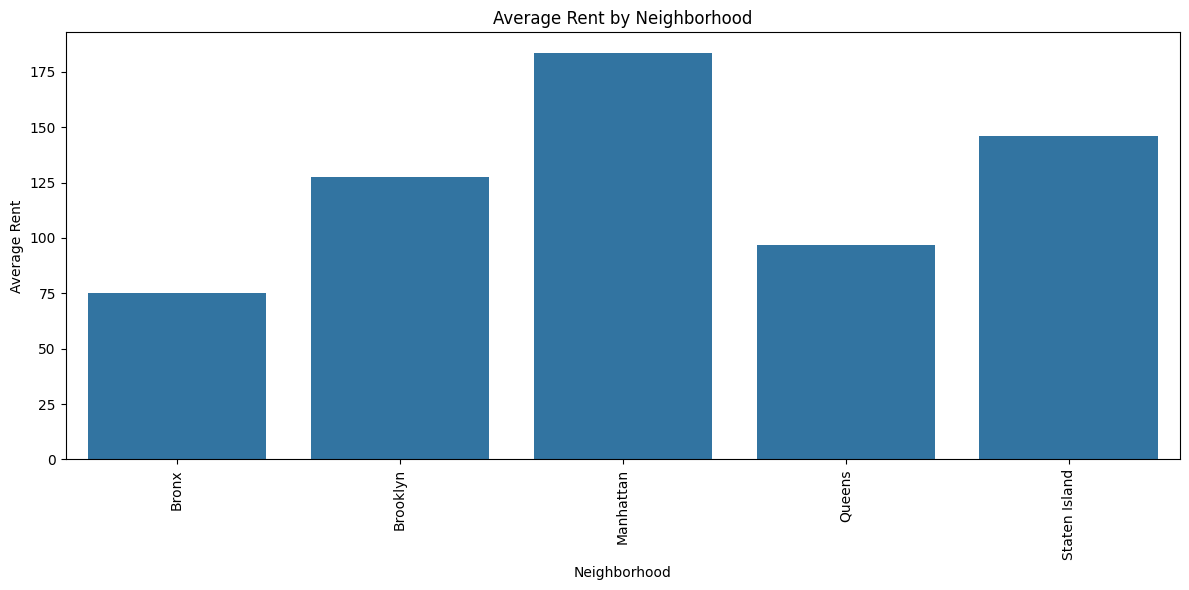

In [5]:
avg_rent_by_neighborhood = data.groupby('Neighbourhood')['Price'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=avg_rent_by_neighborhood, x='Neighbourhood', y='Price')
plt.title('Average Rent by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Average Rent')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

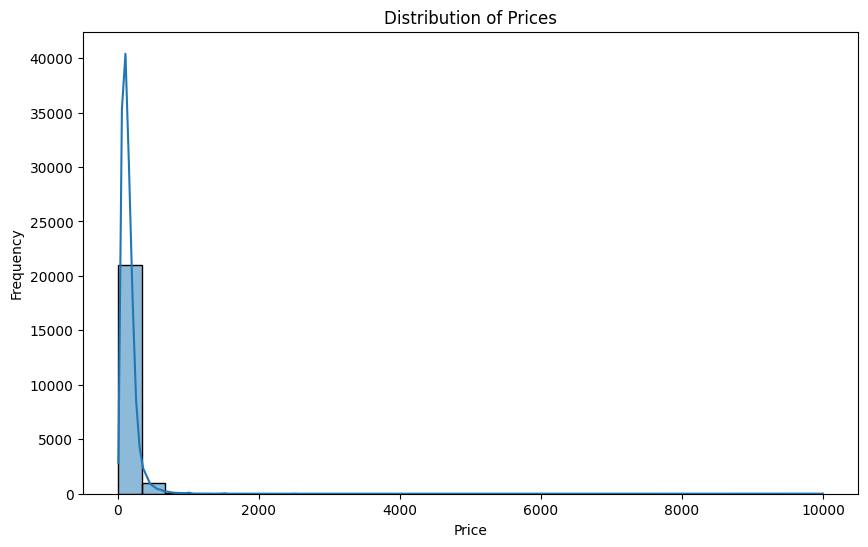

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], bins=30, kde=True)
plt.title('Distribution of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

Ut oh, we are right skewed, lets make sure to normalize price moving forward...

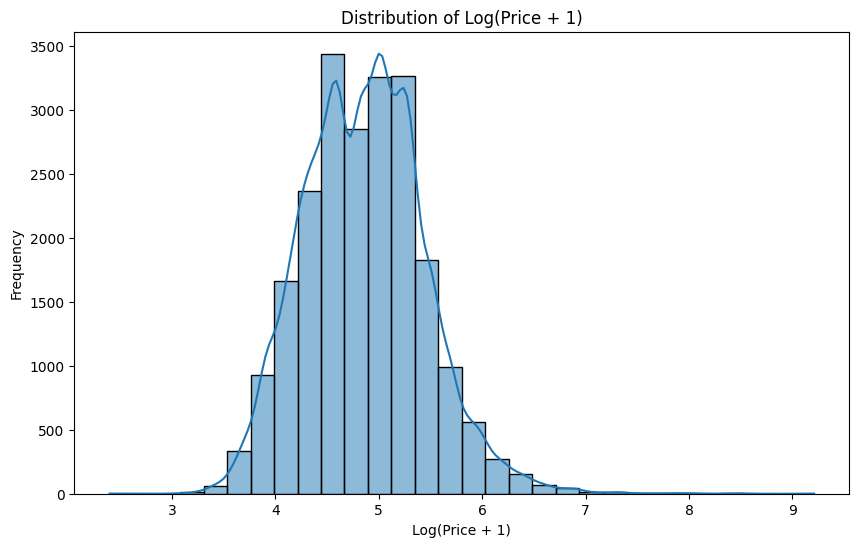

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(np.log1p(data['Price']), bins=30, kde=True)
plt.title('Distribution of Log(Price + 1)')
plt.xlabel('Log(Price + 1)')
plt.ylabel('Frequency')
plt.show()

In [50]:
df.columns

Index(['Host Id', 'Host Since', 'Name', 'Neighbourhood', 'Property Type',
       'Review Scores Rating (bin)', 'Room Type', 'Zipcode', 'Beds',
       'Number of Records', 'Number Of Reviews', 'Price',
       'Review Scores Rating'],
      dtype='object')

#End of EDA, beginning of regression:

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

df_cleaned = df.drop(columns=['Name', 'Host Id', 'Host Since'])

df_cleaned['Price'] = df_cleaned['Price'].astype(float)

df_cleaned['Price'] = np.log1p(df_cleaned['Price'])
numeric_columns = df_cleaned.select_dtypes(include=np.number).columns
df_cleaned[numeric_columns] = df_cleaned[numeric_columns].apply(np.log1p)

df_encoded = pd.get_dummies(df_cleaned, columns=['Neighbourhood', 'Property Type', 'Room Type'], drop_first=True)

df_encoded.dropna(inplace=True)

X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_simple = LinearRegression()
model_simple.fit(X_train, y_train)
y_train_pred = model_simple.predict(X_train)
y_test_pred = model_simple.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("Simple Model Performance:")
print(f"Training RMSE: {rmse_train:.2f}, R squared: {r2_train:.2f}")
print(f"Test RMSE: {rmse_test:.2f}, R squared: {r2_test:.2f}")



Simple Model Performance:
Training RMSE: 0.06, R squared: 0.61
Test RMSE: 0.06, R squared: 0.61


In [105]:
from sklearn.preprocessing import PolynomialFeatures


df_cleaned['Price'] = df_cleaned['Price'].astype(float)

df_encoded = pd.get_dummies(df_cleaned, columns=['Neighbourhood', 'Property Type', 'Room Type'], drop_first=True)
df_encoded.dropna(inplace=True)

X = df_encoded.drop(columns=['Price'])
y = df_encoded['Price']

numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = np.log1p(X[numeric_cols])

poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_interactions, y, test_size=0.2, random_state=42)

model_complex = LinearRegression()
model_complex.fit(X_train, y_train)

y_train_pred_complex = model_complex.predict(X_train)
y_test_pred_complex = model_complex.predict(X_test)

rmse_train_complex = np.sqrt(mean_squared_error(y_train, y_train_pred_complex))
rmse_test_complex = np.sqrt(mean_squared_error(y_test, y_test_pred_complex))
r2_train_complex = r2_score(y_train, y_train_pred_complex)
r2_test_complex = r2_score(y_test, y_test_pred_complex)

print("Complex Model Performance:")
print(f"Training RMSE: {rmse_train_complex:.2f}, R²: {r2_train_complex:.2f}")
print(f"Test RMSE: {rmse_test_complex:.2f}, R²: {r2_test_complex:.2f}")


Complex Model Performance:
Training RMSE: 0.06, R²: 0.63
Test RMSE: 67795.29, R²: -476233962611.24


My biggest takeaway is that more variables isnt always better. For instance, even though the complex model training appears to be similar in performance to the simple model, when tested it fails to hold up to that standard. This is an instance of overfitting, or that there is too much noise to for the model to predict well on the test set.

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('airbnb_hw.csv')

df = df.drop(['Host Since', 'Name', 'Host Id', 'Review Scores Rating (bin)'], axis=1)
df = df.dropna()
df.columns = df.columns.str.strip()

df['Price'] = df['Price'].replace(',', '', regex=True).astype(float)
df['Price'] = np.log1p(df['Price'])

df = pd.get_dummies(df, columns=['Neighbourhood', 'Property Type', 'Room Type'], drop_first=True)

X = df.drop(['Price'], axis=1)
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# LASSO MODEL ATTEMPT
lasso_model = Lasso(alpha=.1)
lasso_model.fit(X_train_scaled, y_train)

selected_features = X.columns[lasso_model.coef_ != 0]
print("Selected Features by Lasso Model:")
print(selected_features)


y_train_pred_lasso = lasso_model.predict(X_train_scaled)
y_test_pred_lasso = lasso_model.predict(X_test_scaled)

rmse_train_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
rmse_test_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print("Lasso Model Performance:")
print(f"Training RMSE: {rmse_train_lasso:.2f}, R squared: {r2_train_lasso:.2f}")
print(f"Test RMSE: {rmse_test_lasso:.2f}, R squared: {r2_test_lasso:.2f}")


Selected Features by Lasso Model:
Index(['Beds', 'Neighbourhood_Manhattan', 'Room Type_Private room',
       'Room Type_Shared room'],
      dtype='object')
Lasso Model Performance:
Training RMSE: 0.42, R squared: 0.47
Test RMSE: 0.43, R squared: 0.46
